# Bayesian Cluster Analysis

In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import wget
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter3_MCMC/data/mixture_data.csv'
filename = wget.download(url)
filename

'mixture_data.csv'

## Eager Execution

In [38]:
def evaluate(tensors):
    if tf.executing_eagerly():
        return tf.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    return sess.run(tensors)

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


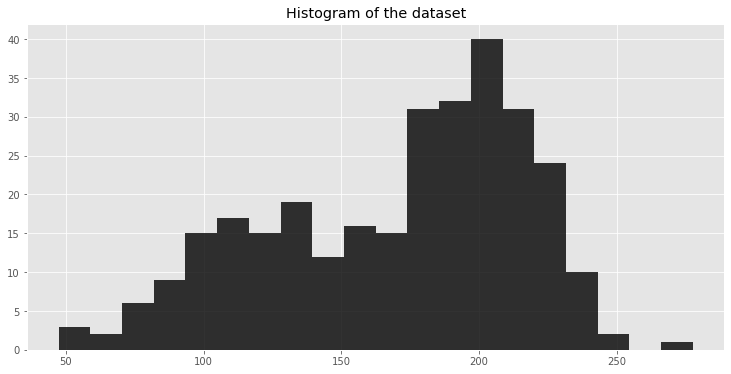

In [7]:
plt.figure(figsize=(12.5, 6))
data_ = np.loadtxt("mixture_data.csv", delimiter=",")

plt.hist(data_, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data_[:10], "...")

In [11]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [46]:
p1 = tfd.Uniform(name='p', low=0., high=1.).sample()
p2 = 1 - p1
p = tf.stack([p1, p2])
# Categorical Assignment Variable
var_assignment = tfd.Categorical(name='assignment', probs=p)
assignment = var_assignment.sample(10)

[ p_, assignment_ ] = evaluate([p, assignment])
p_, assignment_

(array([0.53405964, 0.46594036], dtype=float32),
 array([0, 1, 1, 1, 0, 0, 0, 1, 0, 1], dtype=int32))

In [54]:
var_sds = tfd.Uniform(name='sds', low=[0., 0.], high=[100., 100.])
var_means = tfd.Normal(name='centers', loc=[120., 190.], scale=[10., 10.])
sds = var_sds.sample()
means = var_means.sample()
var_assignment = tfd.Categorical(probs=tf.stack([0.4, 0.6]))
assignments = var_assignment.sample(10)

var_obs = tfd.MixtureSameFamily(
    var_assignment,
    tfd.Normal(loc=means, scale=sds)
)
obs = var_obs.sample(10)
[ assignments_, obs_, sds_, means_ ] = evaluate([
    assignments, obs, sds, means
])

In [56]:
print('Simulated Data: ', obs_)
print('Assignments: ', assignments_)
print('Center: ', means_)
print('Standard Deviation: ', sds_)

Simulated Data:  [178.92705 138.14992 173.88815 191.6725   81.86951 189.62927  92.10466
 394.7831  232.31776 135.05682]
Assignments:  [0 0 1 1 0 0 0 0 0 0]
Center:  [113.64284 191.91629]
Standard Deviation:  [47.266113 88.57577 ]


In [81]:
def joint_log_prob(data, p1, centers, sds):
    var_p = tfd.Uniform(name='p', low=0., high=1.)
    p2 = 1 - p1
    var_assignment = tfd.Categorical(tf.stack([p1, p2]))
    var_sds = tfd.Uniform(name='sds',low=[0., 0.], high=[100., 100.])
    var_means = tfd.Normal(name='centers', loc=[120., 190.], scale=[10., 10.])
    var_obs = tfd.MixtureSameFamily(
        mixture_distribution=var_assignment,
        components_distribution=tfd.Normal(loc=centers, scale=sds)
    )
    
    return (
        var_p.log_prob(p1)
        + var_p.log_prob(p2)
        + tf.reduce_sum(var_obs.log_prob(data))
        + tf.reduce_sum(var_means.log_prob(centers))
        + tf.reduce_sum(var_sds.log_prob(sds))
    )

In [82]:
nsteps = 25000
burn_in = 1000
initial_chain_state = [
    tf.constant(0.5, name='init_p'),
    tf.constant([120., 190.], name='init_means'),
    tf.constant([10., 10.], name='init_sds')
]
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(data_, *args)

In [91]:
step_size = tf.Variable(0.5, name='step_size', trainable=False)

In [83]:
unconstraining_bijectors = [
    tfp.bijectors.Identity(),       # Maps R to R.
    tfp.bijectors.Identity(),       # Maps R to R.
    tfp.bijectors.Identity(),       # Maps R to R.
]

In [93]:
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        step_size=step_size, num_leapfrog_steps=3,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burn_in * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors
)

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:581: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))


In [94]:
[ post_p, post_centers, post_sds ], kernel_results = tfp.mcmc.sample_chain(
    num_results=nsteps, num_burnin_steps=burn_in, current_state=initial_chain_state,
    kernel=hmc
)

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [100]:
evaluate(post_centers).mean(0)

array([117.92831, 198.7684 ], dtype=float32)